# Overview:
#### Requirements to runn this notebook
#### Part 1: Project Purpose and Objectives
#### Part 2: Results
#### Part 3: Training and Setup

## Requirements

* you need to download the following test_dataset and save it in the same folder as the notebook: https://huggingface.co/spaces/IncreasingLoss/Wildlife_Animal_Classifier/tree/main
* if you want to train the model from scratch you can download the Animals_with_Attributes2 dataset here: https://cvml.ista.ac.at/AwA2/
* you need a python 3 environment to do the setup - recomendation use Mamba or Miniconda
* run the following command in your python environment - this should install all the dependencies when not already satisfied
* pip install torch, torchvision, torchmetrics, pillow, numpy, mlxtend, tqdm

## Part 1: Project Purpose and Objectives

#### Inspiration and Background
During my studies in Technical 3D Design in Nürnberg, I discovered image-generating AI systems and became fascinated by their ability to create visual content. This curiosity sparked my journey into machine learning, where I began self-teaching Python and PyTorch. While I gained experience with transfer learning, ComfyUI workflows, and existing model architectures, I had never fully trained a deep vision model from scratch—until this project.
#### Project Goals
* Master the development process of a computer vision model, from dataset preparation to deployment.
* Implement state-of-the-art CNN architectures to benchmark performance.
* Achieve competitive accuracy 
* Deploy a functional prototype for public access, available here: https://huggingface.co/spaces/IncreasingLoss/Wildlife_Animal_Classifier

#### Key Challenges
* Architectural Understanding: Developing a deeper intuition for CNN layer interactions, optimization strategies, and hyperparameter tuning.
* Data Pipeline Design: Curating and balancing a custom dataset with imbalanced class distributions.
* Synthesizing a toy dataset for rapid prototyping and hypothesis testing.
* Testing dataset creation: Sourcing test data for models trained on datasets lacking predefined splits.
* Scaling experiments from small-scale validation to full-dataset training.
* Training Nuances: Contrasting the data volume and computational requirements for training from scratch vs. fine-tuning.

## Part 2: Results

#### Model Considerations
* While deep architectures like ResNet or Inception can achieve near-perfect accuracy, I opted for a smaller model to better match my dataset size and computational constraints.
* Initial tests with VGG showed significant accuracy drops beyond 15-20 classes, likely due to overfitting.
* MobileNetV3-Small proved ideal—balancing speed and accuracy for practical deployment.
* Based on ImageNet benchmarks, expected accuracy falls between 75-85%.
* Results below 75% would indicate suboptimal training or implementation issues.

<img src="trainingpics/output.png" width="900" alt="Description">

#### Confusion Matrix Analysis of the final Model
* Primary Misclassification: Significant confusion between oxen and buffalo, likely due to overlapping visual features in the dataset.
* Secondary Issues: Distant whales occasionally misclassified as dolphins (perspective/scaling challenges)
* Antelopes mistaken for deer (morphological similarities)
* Class Imbalance: Lighter diagonal squares indicate uneven test-set distribution (42 samples for some classes vs. 33–36 for others).

<img src="trainingpics/850images_class.png" width="1200" alt="Description">

#### Training Dynamics: Loss and Accuracy of the final Model
- Key Observation: Increasing divergence between training and test accuracy indicates overfitting beyond epoch 100, prompting early stopping at 100 epochs.
- Critical Trend: While training accuracy continues to improve (14.58% → 97.85%), test accuracy plateaus around 80-83% after epoch 70, suggesting diminishing returns.
* Epoch: 0 || train_loss: 3.0786 || train_acc: 14.5810 || test_loss: 3.1153 || test_acc: 18.5764
* Epoch: 10 || train_loss: 1.5217 || train_acc: 70.0673 || test_loss: 2.5701 || test_acc: 39.1493
* Epoch: 20 || train_loss: 1.3035 || train_acc: 77.9498 || test_loss: 1.8951 || test_acc: 58.5937
* Epoch: 30 || train_loss: 1.1729 || train_acc: 82.8370 || test_loss: 1.5763 || test_acc: 69.0104
* Epoch: 40 || train_loss: 1.0902 || train_acc: 85.3489 || test_loss: 1.4062 || test_acc: 74.9132
* Epoch: 50 || train_loss: 1.0410 || train_acc: 87.0621 || test_loss: 1.5693 || test_acc: 69.6180
* Epoch: 60 || train_loss: 0.9907 || train_acc: 88.8593 || test_loss: 1.4018 || test_acc: 73.9583
* Epoch: 70 || train_loss: 0.9498 || train_acc: 90.2151 || test_loss: 1.3635 || test_acc: 77.6042
* Epoch: 80 || train_loss: 0.8868 || train_acc: 92.4643 || test_loss: 1.3220 || test_acc: 78.8194
* Epoch: 90 || train_loss: 0.8114 || train_acc: 95.2775 || test_loss: 1.3102 || test_acc: 79.5139
* Epoch: 99 || train_loss: 0.7508 || train_acc: 97.8508 || test_loss: 1.2314 || test_acc: 83.3465

#### Model Performance Evaluation
* Final Test Accuracy: 84.46% (epoch 100)
    * This performance aligns with industry standards for lightweight models on similar tasks
* Verify results yourself:
    * Download:
    * Model weights: MobileNet3_small_StateDictionary.pth
    * Test dataset: test_data folder
    * Place both in the notebook's working directory

In [ ]:
'''MobileNetV3 Small class creation'''
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

class hswish(nn.Module):
    def forward(self, x):
        out = x * F.relu6(x + 3, inplace=True) / 6
        return out

class hsigmoid(nn.Module):
    def forward(self, x):
        out = F.relu6(x + 3, inplace=True) / 6
        return out

class SeModule(nn.Module):
    def __init__(self, in_size, reduction=4):
        super(SeModule, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_size, in_size // reduction, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_size // reduction),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_size // reduction, in_size, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_size),
            hsigmoid()
        )

    def forward(self, x):
        return x * self.se(x)

class Block(nn.Module):
    '''expand + depthwise + pointwise'''
    def __init__(self, kernel_size, in_size, expand_size, out_size, nolinear, semodule, stride):
        super(Block, self).__init__()
        self.stride = stride
        self.se = semodule

        self.conv1 = nn.Conv2d(in_size, expand_size, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(expand_size)
        self.nolinear1 = nolinear
        self.conv2 = nn.Conv2d(expand_size, expand_size, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, groups=expand_size, bias=False)
        self.bn2 = nn.BatchNorm2d(expand_size)
        self.nolinear2 = nolinear
        self.conv3 = nn.Conv2d(expand_size, out_size, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_size)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_size != out_size:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_size, out_size, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_size),
            )

    def forward(self, x):
        out = self.nolinear1(self.bn1(self.conv1(x)))
        out = self.nolinear2(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        if self.se != None:
            out = self.se(out)
        out = out + self.shortcut(x) if self.stride==1 else out
        return out

class MobileNetV3_Small(nn.Module):
    def __init__(self, num_classes= 30):
        super(MobileNetV3_Small, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.hs1 = hswish()

        self.bneck = nn.Sequential(
            Block(3, 16, 16, 16, nn.ReLU(inplace=True), SeModule(16), 2),
            Block(3, 16, 72, 24, nn.ReLU(inplace=True), None, 2),
            Block(3, 24, 88, 24, nn.ReLU(inplace=True), None, 1),
            Block(5, 24, 96, 40, hswish(), SeModule(40), 2),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 120, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 144, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 288, 96, hswish(), SeModule(96), 2),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
        )


        self.conv2 = nn.Conv2d(96, 576, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(576)
        self.hs2 = hswish()
        self.linear3 = nn.Linear(576, 1280)
        self.bn3 = nn.BatchNorm1d(1280)
        self.hs3 = hswish()
        self.linear4 = nn.Linear(1280, num_classes)
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.hs1(self.bn1(self.conv1(x)))
        out = self.bneck(out)
        out = self.hs2(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 7)
        out = out.view(out.size(0), -1)
        out = self.hs3(self.bn3(self.linear3(out)))
        out = self.linear4(out)
        return out

* Accuracy: Expected range of 82-86% when executing the next code block
* Inference Speed: Achieves ~160 FPS on RTX 4080 GPU
* Confusion Matrix: Results should closely match the reference visualization above

In [ ]:
"""Loading the model"""
user_device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_mobilenet3 = MobileNetV3_Small()
loaded_mobilenet3.load_state_dict(torch.load("models/MobileNet3_small_StateDictionary.pth", weights_only=True)) 
loaded_mobilenet3 = loaded_mobilenet3.to(user_device)


"""creating test_data"""
import torchvision
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),  
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_data = torchvision.datasets.ImageFolder("data/Animals_with_Attributes2/test", test_transforms, None)


"""Running predictions on the data"""
from tqdm.auto import tqdm
import torchmetrics

preds = []
test_acc = 0
for image, label  in tqdm(test_data):
    image, label = image.to(user_device), torch.tensor(label).to(user_device)
    loaded_mobilenet3.eval()
    with torch.inference_mode():
        logits = loaded_mobilenet3(image.unsqueeze(dim=0))
        pred = logits.argmax(dim=1)
        preds.append(pred)

preds_tensor = torch.tensor(preds, dtype=torch.long)
label_tensor = torch.tensor(test_data.targets, dtype=torch.long)
acc_fn = torchmetrics.Accuracy(task="multiclass", num_classes=len(test_data.classes))
test_acc = acc_fn(preds_tensor, label_tensor)*100 
print("expected Accuracy 82-86%")
print(f"Test Accuracy: {test_acc:.4f}%")

"""creating a confusion matrix"""
confusion_matrix_fn = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=len(test_data.classes))
confusion_matrix_tensor = confusion_matrix_fn(preds_tensor, label_tensor)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix_tensor.numpy(), class_names=test_data.classes, figsize=(9,9))

#### Results Summary
* These benchmarks demonstrate the model's competitive performance - I'm excited to share them!
* Next, I'll walk through the key techniques that made these results possible:
    * Code implementation details   
    * Performance optimization breakdown
    * Lessons learned from the training process

## Part 3: Training and Setup

#### Getting the Data
* Dataset Preparation
* Note: Transforms will be discussed in detail later - first, let's load the data.
* Source: "Animals_with_Attributes2" dataset was cut down in size since some classes were only represented with very few images
* Custom test set: manually curated images per class (sourced from Google Images)
* Class Selection:
    * ['antelope', 'buffalo', 'chimpanzee', 'cow', 'deer', 'dolphin', 
 'elephant', 'fox', 'giant+panda', 'giraffe', 'gorilla', 'grizzly+bear',
 'hamster', 'hippopotamus', 'horse', 'humpback+whale', 'leopard', 'lion',
 'moose', 'otter', 'ox', 'pig', 'polar+bear', 'rabbit', 'rhinoceros',
 'seal', 'sheep', 'squirrel', 'tiger', 'zebra']

In [ ]:
"""creating transforms and dataloaders"""
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(300),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2),
    transforms.RandomRotation(degrees=(-20, 20)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Changed to match train size
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

"""creating datasets from custom data"""
from torchvision.datasets import ImageFolder
train_data = ImageFolder(root= "data/Animals_with_Attributes2/train", transform= train_transforms, target_transform=None)       # CHANGE THE PATH TO YOUR FOLDER
test_data = ImageFolder(root= "data/Animals_with_Attributes2/test", transform = test_transforms, target_transform=None)         # CHANGE THE PATH TO YOUR FOLDER

"""create dataloader from datasets"""
from torch.utils.data import DataLoader
batch = 64
train_loader = DataLoader(train_data, batch, shuffle=True, num_workers=0, drop_last= True)
test_loader = DataLoader(test_data, batch, shuffle=False, num_workers=0, drop_last=True)

#### Data Validation Checks
* Before training, I always verify two critical aspects of my image data pipeline:
* Correct Loading & Labeling:
    * Confirming images match their assigned class labels
    * Checking for corrupted or mislabeled files
    * Dataloader Output Dimensions
    * Validating batch shapes: [batch_size, channels, height, width]
    
Visualization Code:

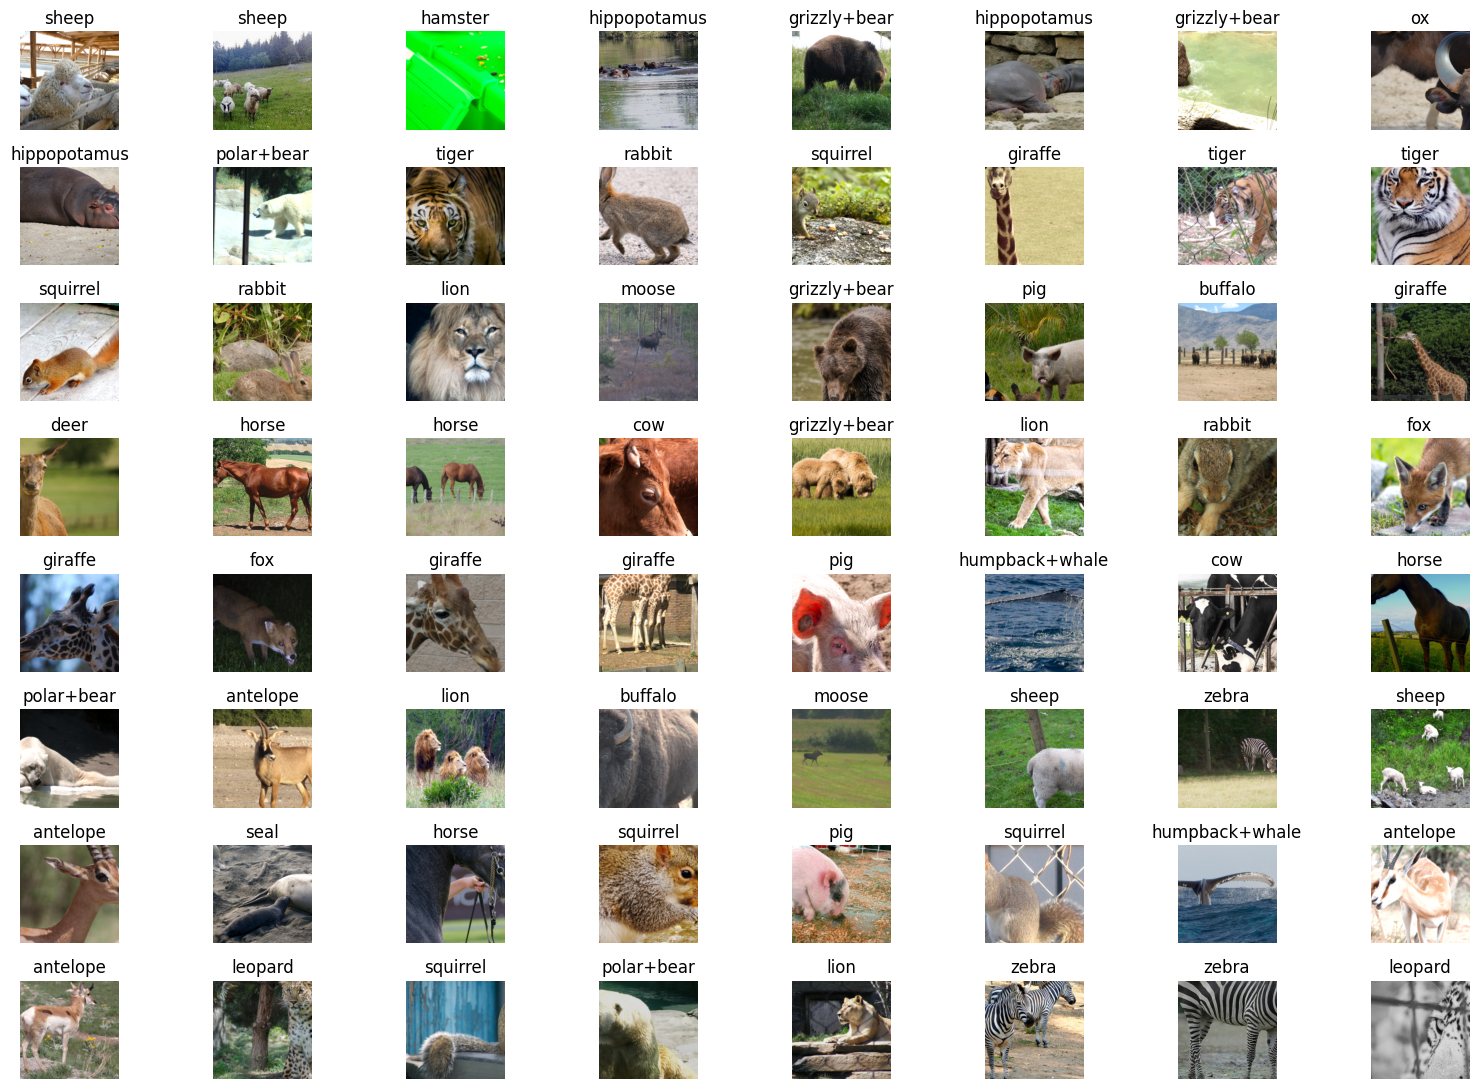

the shape of: torch.Size([64, 3, 224, 224]) is correct we are looking at 64 images with 3 channels and a size of 244x244
the 30 classes are also being recognied correctly: 30


In [65]:
"""vizualize batch and data"""
import matplotlib.pyplot as plt
import numpy as np
def show_batch(data_loader, class_names=None, denormalize=False, figsize=(12, 8)):
    # Get batch and move to CPU because matplotlib needs cpu
    images, labels = next(iter(data_loader))
    images = images.cpu()
    
    # Denormalize if requested
    if denormalize:
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        images = images * std + mean
        images = torch.clamp(images, 0, 1)  # Maintain valid pixel range
    
    # Setup plot
    class_names = class_names or [str(i) for i in range(10)]
    batch_size = len(images)
    grid_size = int(np.ceil(np.sqrt(batch_size)))
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=figsize)
    axes = axes.flatten()
    
    # Plot images
    for ax, img, label in zip(axes, images, labels):
        # Convert tensor to numpy and permute dimensions
        img_np = img.permute(1, 2, 0).numpy()
        ax.imshow(img_np)
        ax.set_title(class_names[label])
        ax.axis('off')
    
    # Hide empty subplots
    for j in range(batch_size, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()
show_batch(train_loader, train_data.classes, denormalize=True, figsize=(16,11))

"""looking at shapes and dimensions"""
images, labels = next(iter(train_loader))
print(f"the shape of: {images.shape} is correct we are looking at 64 images with 3 channels and a size of 244x244")
print(f"the 30 classes are also being recognied correctly: {len(train_data.classes)}")

#### Class Imbalance Mitigation
* Initial Approach: "total_number_of_images / number_of_classes"
* Issue: This over-prioritized majority classes due to skew in sample counts
* Refined Solution:
    * Set a manual baseline (850 samples) - below dataset average but above minimum
    * compute weights as  "baseline / samples_per_class"
    * use this weights in CrossentropyLoss
* Code:

The classes are not blanaced: [1046, 895, 728, 1338, 1344, 946, 1038, 664, 874, 1202, 872, 852, 779, 684, 1645, 709, 720, 1019, 704, 758, 728, 713, 868, 1088, 696, 988, 1420, 1200, 877, 1170]


<BarContainer object of 30 artists>

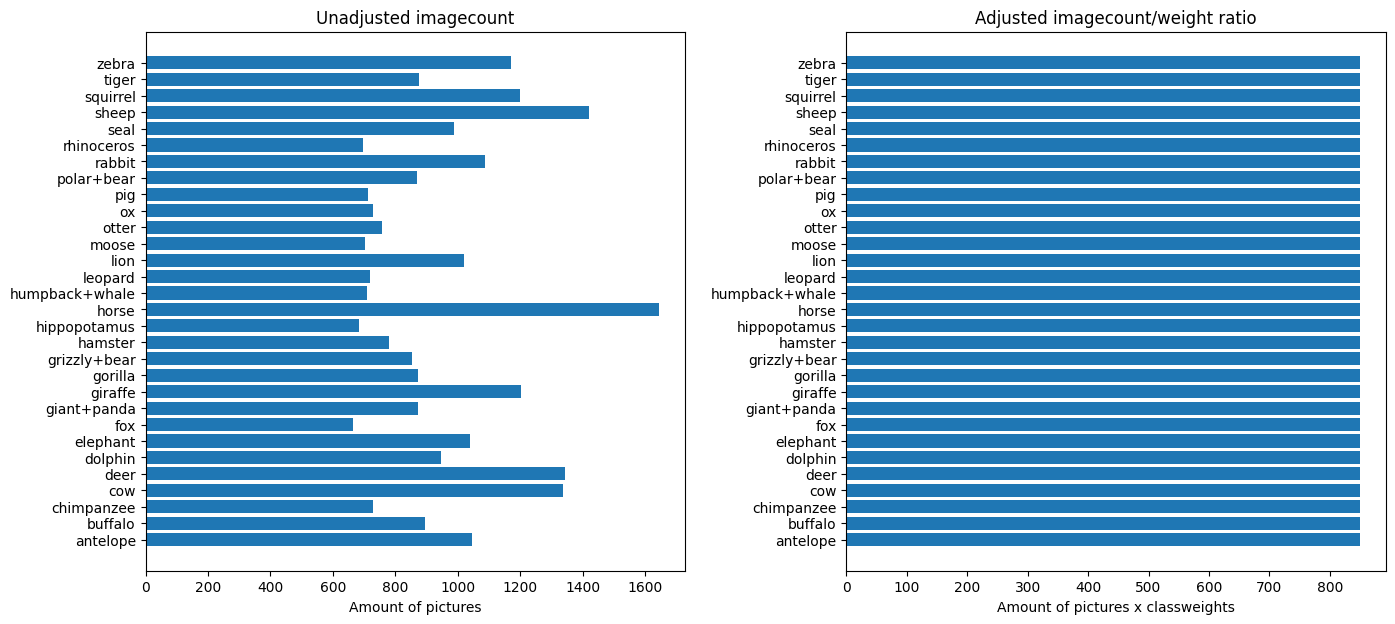

In [70]:
"""checking the shapes and the classbalance"""
import os
def return_class_imbalance(main_dir: str) -> list:
    number_list = []
    valid_extensions = {'.jpg', '.jpeg', '.png', '.webp', '.bmp', '.tiff', '.gif'}
    
    # Validate input directory
    if not os.path.isdir(main_dir):
        raise ValueError(f"Directory {main_dir} does not exist or is not a directory")
    
    # Get sorted list of immediate subdirectories
    subdirs = sorted([d for d in os.listdir(main_dir) 
                     if os.path.isdir(os.path.join(main_dir, d))])
    
    # Count images in each subdirectory
    for subdir in subdirs:
        subdir_path = os.path.join(main_dir, subdir)
        count = 0
        
        # Walk through all files in subdirectory tree
        for root, dirs, files in os.walk(subdir_path):
            for file in files:
                ext = os.path.splitext(file)[1].lower()
                if ext in valid_extensions:
                    count += 1
                    
        number_list.append(count)
    
    return number_list

classimablance = return_class_imbalance("data/Animals_with_Attributes2/train")
print(f"The classes are not blanaced: {classimablance}")

"""creating classweights for crossentropy loss since data is imbalanced"""
classweights = []
for imagenumber in classimablance:
    classweights.append(850/imagenumber)

classweights = torch.tensor(classweights).to(user_device)
classimablance = torch.tensor(classimablance).to(user_device)

"""visualizing class imbalance"""
plt.figure(figsize=(16,7))
plt.subplots_adjust(wspace=.3)
plt.subplot(1,2,1)
plt.xlabel("Amount of pictures")
plt.barh(train_data.classes, classimablance.to("cpu"))
plt.title("Unadjusted imagecount")

plt.subplot(1,2,2)
plt.title("Adjusted imagecount/weight ratio")
plt.xlabel("Amount of pictures x classweights")
plt.barh(train_data.classes, classweights.to("cpu")* classimablance.to("cpu"))

#### Hyperparameter Optimization Process
* All final values were determined through systematic experimentation
* Initial testing used a controlled toy dataset:
    * 5 representative classes
    * 300 images per class (balanced distribution)
    * 50-epoch training cycles for rapid iteration
* Optimizing using the AdamW Optimizer:
    * Start: batchsize of 16 and yielded an test accuracy of 48%
        * increasing the batchsize to 32 yielded an test accuarcy of 62%
        * increasing the batchsize to 64 yielded an test accuarcy of 67%
        * increasing the batchsize to 96 yielded an test accuarcy of 59% and the model started to overtrain 
        * so i did the rest of my training using a batchsize of 64 
    * increased epochs to 100
        * Plateau Detection: Training loss stabilized at ~1.5, Test accuracy capped at 65-70%
        * CosineAnnealingLR Implementation: Improved test accuracy to 72-78%, Reduced training loss to ~0.9 (still suboptimal)
        * train_loss stuck at ~0.9 
* SWITCH to weighted SGD and back to 50 epochs
    * Research: benchmarks from kaggle 
    * Intel: most of the industry standart models are trained using SGD 
    * Initial Results: test accuracy of about 50%
    * using the OneCycleLR scheduler i was able to get the test accuracy back to 69%
        * adjusting max_lr, pc_start, and both start_div and final_div_factors
    * switching to a 100 epochs
        * this yielded in my first score of 86-88% test accuracy with a training loss of 0.73 

In [ ]:
"""Configured Optimizer"""
epochs_1 = 100

optimizer_1 = torch.optim.SGD(
    loaded_mobilenet3.parameters(),
    lr=0.05,          # Placeholder; will be overwritten by the scheduler
    momentum=0.85,    # Placeholder: will be overwritten by the scheduler
    nesterov=True,
    weight_decay=1e-4
)

"""Configured Scheduler"""
scheduler_1 = torch.optim.lr_scheduler.OneCycleLR(
    optimizer_1,
    max_lr=0.2,            
    pct_start=0.2,          # Warmup lasts 20% of the cycle
    div_factor=10,          
    final_div_factor=330,   
    steps_per_epoch=len(train_loader),
    epochs=epochs_1,             # Total training epochs 
    anneal_strategy='linear',
    base_momentum=0.85,     
    max_momentum=0.90       
    )

![alt text](<trainingpics/lr=0.2   pct=0.2   div=10   finaldiv=330     train_loss= 0.0021  train_acc=99,928  test_loss= 7,29  test_acc =35,874.png>)

#### Scaling Challenges & Solutions
* Initial Scaling Attempt:
    * Applied a second toy dataset 15 classes (300 images/class)
    * Result: Severe overfitting → 37.5% test accuracy

* Key Improvements:
    * Increased to 850 images/class → 65-75% test accuracy
    * Aggressive Augmentation

* Lessons Learned:
    * Small-dataset optimizations don’t scale linearly
    * Data quality/quantity > model tuning at larger scales

In [67]:
from torchvision import transforms

"""my original transforms looked like this for the training data it had little to no augmentation"""
train_transforms = transforms.Compose([
    transforms.Resize(244),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor(),])

* Most Effective Transforms:
    * Normalization: Stabilized training dynamics
    * Random Crop: Forced focus on relevant features
* Rejected Techniques:
    * Random Erase: Removed due to risk of deleting key features
* Color Jitter Tuning:
    * Reduced intensity to preserve color-based learning cues
    * Balanced shape/texture/color feature extraction
* Final Result: 83% test accuracy - Optimal trade-off between robustness and generalization

In [ ]:
"""the new transforms:"""
train_transforms = transforms.Compose([
    transforms.Resize(300),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2),
    transforms.RandomRotation(degrees=(-20, 20)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

#### Loss Function Optimization
* Base Configuration: CrossEntropyLoss with class weights (from imbalance mitigation)
* Label Smoothing Tests:
    * Smoothing         |   0       |   0.1             |   0.2
    * TrainingLoss      |   __      |   minor Increase  |   +37% 
    * Test Accuracy     |   83%     |   85%             |   82%

* Key Insight:
    * 0.1 smoothing improved generalization without significant loss degradation
    * Higher values caused label dilution (accuracy plateau + loss spike)

In [68]:
loss_fn = nn.CrossEntropyLoss(weight=classweights, label_smoothing=0.1)
acc_fn = torchmetrics.Accuracy(task="multiclass", num_classes=len(test_data.classes)).to(user_device)

#### Training Pipeline Components
* Core Functions: Standard training loop with:
    * Batch iteration
    * Loss calculation
    * Backpropagation
    * Metric tracking
* Tested & Removed:
    * MixUp augmentation (image/label mixing)
    * Result: 80-82% accuracy (vs. baseline 85.5%)
    * Parameters Tried: Mix ratios [0.025, 0.3]

* Critical Addition:
    * Gradient clipping (max_norm=1.0) to prevent exploding gradients
    * Stabilized early training phases

In [ ]:
import numpy as np

# training & testing loop
def train_step_CNN(MODEL: torch.nn.Module,
               LOADER: torch.utils.data.DataLoader,
               LOSSF: torch.nn.Module,
               ACCF: torchmetrics.Accuracy,
               OPTIM: torch.optim.Optimizer,
               SCHEDULER: None,
               DEVICE: torch.device):
    """Performs a CNN training step over a dataloader"""
    MODEL.train()
    train_loss, train_acc = 0, 0
    for image, label in LOADER:
        image, label = image.to(DEVICE), label.to(DEVICE)

        # MixUp - IMAGES ONLY
        #lam = np.random.uniform(0.025, 0.3)
        #index = torch.randperm(image.size(0))
        #mixed_images = lam * image + (1 - lam) * image[index]

        #training
        #logits = MODEL(mixed_images)
        logits = MODEL(image)

        # MixUp LABEL HANDLING
        #label_a = label
        #label_b = label[index]
        #mixed_labels = lam * label + (1 - lam) * label[index]

        #batch_loss = lam * loss_fn(logits, label_a) + (1 - lam) * loss_fn(logits, label_b)
        batch_loss = LOSSF(logits, label)
        train_loss += batch_loss
        #preds = torch.argmax(logits, dim=1)
        #is_correct = (preds == label_a) | (preds == label_b)  # Either original label
        #train_acc += is_correct.float().mean() * 100  # Percentage
        train_acc += ACCF(logits.argmax(dim=1), label)

        OPTIM.zero_grad()
        batch_loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(MODEL.parameters(), max_norm=1.0)
        
        OPTIM.step()

        if SCHEDULER != None:
            SCHEDULER.step()

    train_acc /= len(LOADER)*0.01
    train_loss /= len(LOADER)
    return train_loss, train_acc


def test_step_CNN(MODEL: torch.nn.Module,
                  LOADER: torch.utils.data.DataLoader,
                  LOSSF: torch.nn.Module,
                  ACCF: torchmetrics.Accuracy,
                  DEVICE: torch.device):
    """Performs a CNN testing step over a dataloader"""
    MODEL.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for image, label in LOADER:
            image, label = image.to(DEVICE) , label.to(DEVICE)
            logits = MODEL(image)
            batch_loss = LOSSF(logits, label)
            test_loss += batch_loss
            test_acc += ACCF(logits.argmax(dim=1), label)
        test_acc /= len(LOADER)*0.01
        test_loss /= len(LOADER)
        return test_loss, test_acc

from tqdm.auto import tqdm
def model_training_CNN(MODEL: torch.nn.Module,
               LOADER_TRAIN: torch.utils.data.DataLoader,
               LOADER_TEST: torch.utils.data.DataLoader,
               LOSSF: torch.nn.Module,
               ACCF: torchmetrics.Accuracy,
               OPTIM: torch.optim.Optimizer,
               DEVICE: torch.device,
               SCHEDULER: None,
               EPOCHS_TRAIN: int,
               Epochs_RETURN: int):
    """Combines "train_step_CNN" & "test_step_CNN" into one training function"""
    
    evaluation_dictionary = {"train_loss": [],
                             "train_acc": [], 
                             "test_loss": [],
                             "test_acc": [],
                             "epoch":[]}

    for epoch in tqdm(range(EPOCHS_TRAIN)):

        train_loss, train_acc = train_step_CNN(MODEL, LOADER_TRAIN, LOSSF, ACCF, OPTIM, SCHEDULER, DEVICE)    
        test_loss, test_acc = test_step_CNN(MODEL, LOADER_TEST, LOSSF, ACCF, DEVICE)    
        
        #append to eval_dict
        if epoch%Epochs_RETURN == 0:
            evaluation_dictionary["train_loss"].append(train_loss.cpu().detach().numpy())
            evaluation_dictionary["train_acc"].append(train_acc.cpu())
            evaluation_dictionary["test_loss"].append(test_loss.cpu())
            evaluation_dictionary["test_acc"].append(test_acc.cpu())
            evaluation_dictionary["epoch"].append(epoch)
            print(f"Epoch: {epoch} || train_loss: {train_loss:.4f} || train_acc: {train_acc:.4f} || test_loss: {test_loss:.4f} || test_acc: {test_acc:.4f}")

    return evaluation_dictionary

eval_dict = None       

#### Using the Trainingloop
* Training can take some time depending on the amount of data 
* Time: 100 epochs -> 8 hours -> with 950 images per class x 30 classes

In [ ]:
eval_dict = model_training_CNN(MODEL=loaded_mobilenet3,
                   LOADER_TRAIN= train_loader,
                   LOADER_TEST= test_loader,
                   LOSSF=loss_fn,
                   ACCF=acc_fn,
                   OPTIM= optimizer_1,
                   SCHEDULER= scheduler_1,
                   DEVICE= user_device, 
                   EPOCHS_TRAIN=epochs_1,
                   Epochs_RETURN=1)

#### PLotting the Loss and Accuracy Graphs
* Training Dynamics Visualization
* Enables convergence analysis and generalization  monitoring
* Critical Use Cases:
    * Detect learning stagnation (flatlining loss/accuracy curves)
    * Identify under/overfitting patterns (diverging train-test metrics)
* Dependent on training state_dict from the training loop

In [62]:
def plot_eval_dict(dict, fig_size= (14,5), start_epoch: int = 1, num_epochs: int=1000000):
    plt.figure(figsize= fig_size)
    plt.subplot(1,2,1)
    plt.plot(dict["epoch"][start_epoch:num_epochs], dict["train_loss"][start_epoch:num_epochs], color = "blue", label="train_loss")
    plt.plot(dict["epoch"][start_epoch:num_epochs], dict["test_loss"][start_epoch:num_epochs], color = "red", label="test_loss")
    plt.legend()
    plt.title("LOSS")

    plt.subplot(1,2,2)
    plt.plot(dict["epoch"][start_epoch:num_epochs], dict["train_acc"][start_epoch:num_epochs], color = "blue", label="train_acc")
    plt.plot(dict["epoch"][start_epoch:num_epochs], dict["test_acc"][start_epoch:num_epochs], color = "red", label="test_acc")
    plt.legend()
    plt.title("ACCURACY")
if eval_dict != None:
    plot_eval_dict(eval_dict, fig_size=(16,5), start_epoch=0)
else:
    print("eval_dict is empty!!! Runn training to plot graphs!!!")   

eval_dict is empty!!! Runn training to plot graphs!!!


#### Conditional Saving
* Performance Validation: After each training, comprehensive evaluation across the entire test dataset is conducted. This accounts for the inherent stochasticity in neural network optimization, where random weight initialization and gradient updates can yield variable outcomes.
* Improvement Thresholding: Models are selectively preserved only when test accuracy surpasses prior iterations. This prevents storage regressions caused by training instability.


In [69]:
#create folder structure and name 
from pathlib import Path
acc_fn = torchmetrics.Accuracy("multiclass", num_classes=len(test_data.classes)).to(user_device)
loaded_mobilenet3 = loaded_mobilenet3.to(user_device)

"""calc test accuracy"""
acc_threshhold = 85.1212 # set this as the measured test acc from the previous run
test_acc = 0
loaded_mobilenet3.eval()
with torch.inference_mode():
    for images, labels in tqdm(test_data):
        images, labels = images.to(user_device), torch.tensor(labels,dtype=torch.float).to(user_device)
        logits = loaded_mobilenet3(images.unsqueeze(dim=0))
        #print(logits.argmax(dim=1))
        #print(label.unsqueeze(dim=0))
        test_acc += acc_fn(logits.argmax(dim=1), labels.unsqueeze(dim=0))
    test_acc /= len(test_data)*0.01

print(f"test_acc: {test_acc:.4f}% vs acc_threshold {acc_threshhold}%")

"""Saving the model"""
if(test_acc>acc_threshhold):
    #create dir if not existent
    model_path = Path("models")
    model_path.mkdir(parents=True, exist_ok=True)
    MobileNet_model_small = loaded_mobilenet3.to("cpu")
    # save state dic
    print(f"acc {test_acc} higher than {acc_threshhold} saving model")
    model_save_path = model_path / "MobileNet3_small_StateDictionary.pth"
    print("saving model to:", model_save_path)
    torch.save(obj=MobileNet_model_small.state_dict(), f= model_save_path)
else:
    print("Last model performed better, no saving")

  0%|          | 0/1156 [00:00<?, ?it/s]

test_acc: 85.1211% vs acc_threshold 85.1212%
Last model performed better, no saving
